In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/MyDrive/Video_training/takehome.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Malignant/1530.jpg  
  inflating: train/Malignant/1531.jpg  
  inflating: train/Malignant/1532.jpg  
  inflating: train/Malignant/1533.jpg  
  inflating: train/Malignant/1534.jpg  
  inflating: train/Malignant/1535.jpg  
  inflating: train/Malignant/1536.jpg  
  inflating: train/Malignant/1537.jpg  
  inflating: train/Malignant/1538.jpg  
  inflating: train/Malignant/1539.jpg  
  inflating: train/Malignant/154.jpg  
  inflating: train/Malignant/1540.jpg  
  inflating: train/Malignant/1541.jpg  
  inflating: train/Malignant/1542.jpg  
  inflating: train/Malignant/1543.jpg  
  inflating: train/Malignant/1544.jpg  
  inflating: train/Malignant/1545.jpg  
  inflating: train/Malignant/1546.jpg  
  inflating: train/Malignant/1547.jpg  
  inflating: train/Malignant/1548.jpg  
  inflating: train/Malignant/1549.jpg  
  inflating: train/Malignant/155.jpg  
  inflating: train/Malignant/1550.jpg  
  inflating: train/Malignant/15

In [3]:
# Install Torch if needed
# !pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set batch size and image dimensions
batch_size = 128
img_height = 256
img_width = 256

# Augmentation for training data
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(p=0.5),           # Flip 50% of images
    transforms.RandomRotation(degrees=20),             # Randomly rotate +/- 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)), # Random crop zoom
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet means & std
                         std=[0.229, 0.224, 0.225])
])

# Simple transform for validation & test (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths to dataset
train_dir = "/content/train"
test_dir = "/content/test"

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)  # Augment train
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)          # Plain test

# Split training data into train & validation sets (80-20 split)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Apply train transform to training split, test transform to validation split
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Override validation dataset's transform (no augmentation for val)
val_dataset.dataset.transform = test_transform

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print class names
class_names = full_train_dataset.classes
print("Class Names:", class_names)



Class Names: ['Benign', 'Malignant']


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        # Placeholder for the fully connected layer (we'll compute the input size dynamically)
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)

        if self.fc1 is None:
            # Infer the input size to fc1 dynamically
            self.fc1 = nn.Linear(x.shape[1], 128).to(x.device)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



num_classes = 2

model = SimpleCNN(num_classes)

print(model)



SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=2).to(device)

print(model)

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [7]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5,mode = 'max',verbose=True)
epochs = 50
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = 100 * correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Step the scheduler
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
epochs = 100
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
)


Epoch [1/100] - Train Loss: 0.6918, Train Acc: 51.43% - Val Loss: 0.6883, Val Acc: 53.75%
Epoch [2/100] - Train Loss: 0.6860, Train Acc: 53.24% - Val Loss: 0.6828, Val Acc: 54.46%
Epoch [3/100] - Train Loss: 0.6806, Train Acc: 54.92% - Val Loss: 0.6768, Val Acc: 56.40%
Epoch [4/100] - Train Loss: 0.6740, Train Acc: 56.94% - Val Loss: 0.6690, Val Acc: 58.00%
Epoch [5/100] - Train Loss: 0.6651, Train Acc: 58.46% - Val Loss: 0.6583, Val Acc: 60.86%
Epoch [6/100] - Train Loss: 0.6532, Train Acc: 61.97% - Val Loss: 0.6447, Val Acc: 64.77%
Epoch [7/100] - Train Loss: 0.6378, Train Acc: 65.88% - Val Loss: 0.6267, Val Acc: 68.77%
Epoch [8/100] - Train Loss: 0.6179, Train Acc: 70.47% - Val Loss: 0.6042, Val Acc: 73.06%
Epoch [9/100] - Train Loss: 0.5952, Train Acc: 73.78% - Val Loss: 0.5820, Val Acc: 75.84%
Epoch [10/100] - Train Loss: 0.5755, Train Acc: 76.00% - Val Loss: 0.5650, Val Acc: 77.15%
Epoch [11/100] - Train Loss: 0.5605, Train Acc: 77.95% - Val Loss: 0.5510, Val Acc: 79.42%
Epoch [1

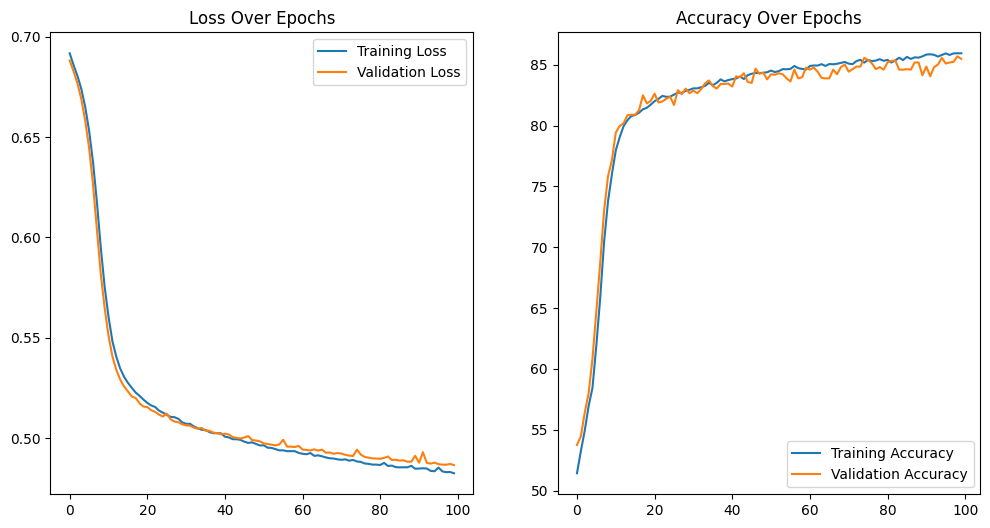

In [9]:
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_history, label='Training Loss')
plt.plot(range(epochs), val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_history, label='Training Accuracy')
plt.plot(range(epochs), val_acc_history, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


In [10]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

# Evaluate
evaluate_model(model, test_loader)


Test Accuracy: 84.75%


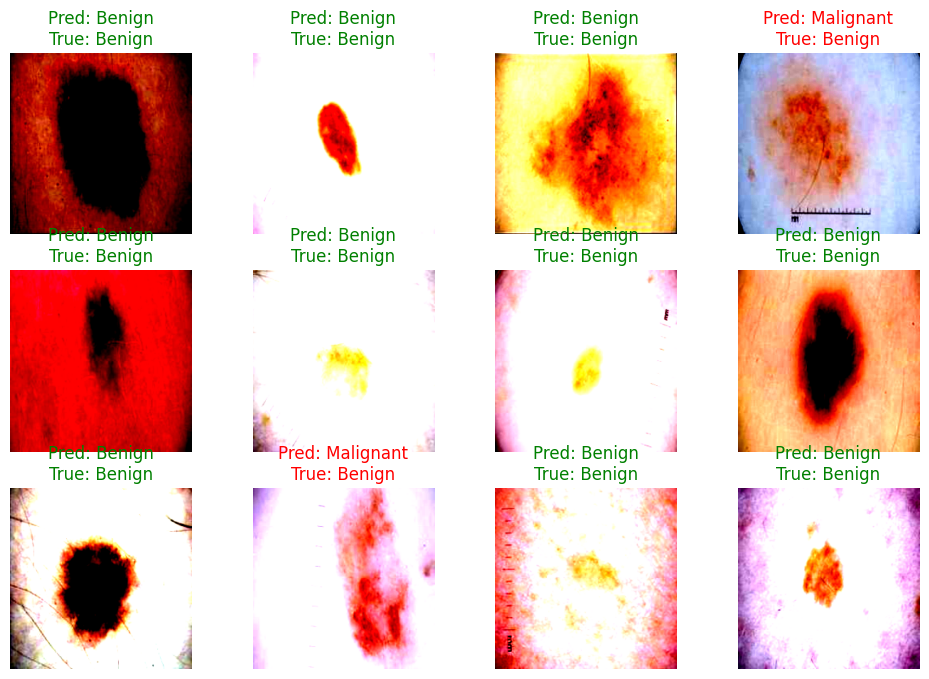

In [11]:
def predict_and_plot(model, test_loader, class_names):
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i+1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        color = "green" if predictions[i] == labels[i] else "red"
        plt.title(f"Pred: {class_names[predictions[i]]}\nTrue: {class_names[labels[i]]}", color=color)
        plt.axis("off")

    plt.show()

# Run visualization
predict_and_plot(model, test_loader, class_names)
